# XAI - homework 3

Mateusz Biesiadowski mb406097

# Report

### 1) Train a tree-based ensemble model on the selected dataset
I trained a RandomForestClassifier on a heart-attack-analysis-prediction-dataset

### 2) Then, calculate the decomposition of these predictions with LIME using the package of choice, e.g. in Python: lime, dalex

I used dalex:

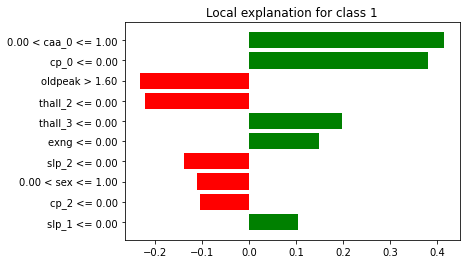

### 3) Compare LIME for various observations in the dataset. How stable are these explanations?

Explanations differs for different observations. Explanations are seed related so they depends on initialisation points for linear model.

---
Patient 0
---

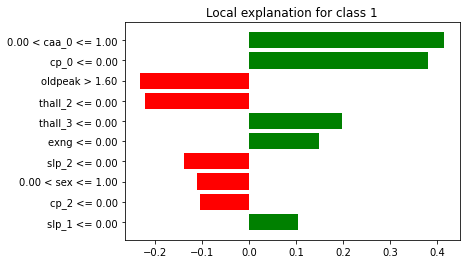

---
Patient 1
---
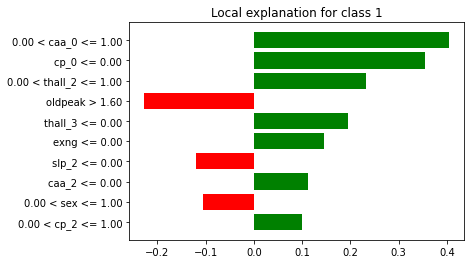

### 4) Compare LIME with the explanations obtained using SHAP. What are the main differences between them?

Some of the attributions differs between LIME and SHAP explanation. The differences are both in sentiment and value of attribution.

---

Patient 0

---
- LIME
---
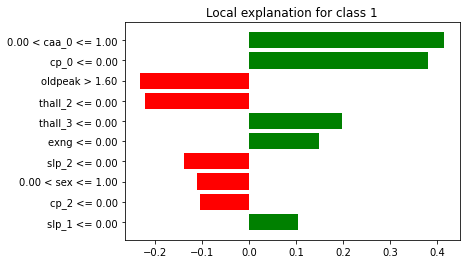
---
---
- SHAP
---
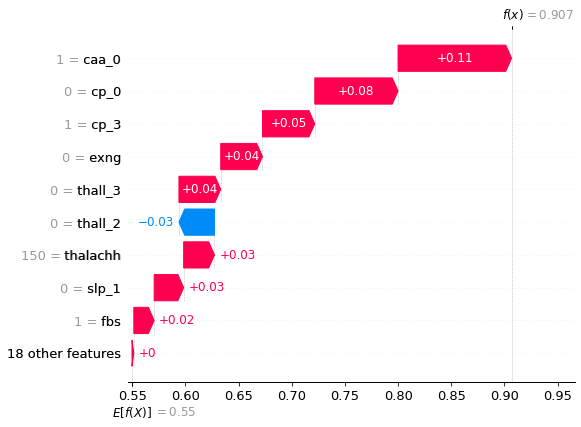

### 5) Compare LIME between at least two different models. Are there any systematic differences across many observations?

There are some differences, but explanations are quite similar in the same observation.

---
- OBS 0
---
RandomForest
---
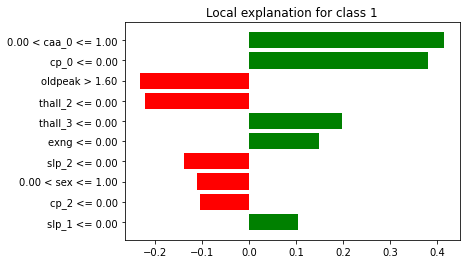
---
DecisionTree
---
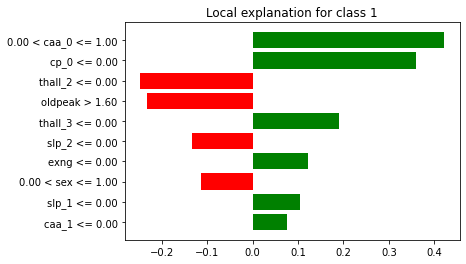
---
---
- OBS 1
---
RandomForest
---
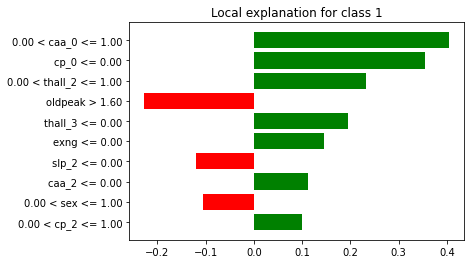
---
DecisionTree
---
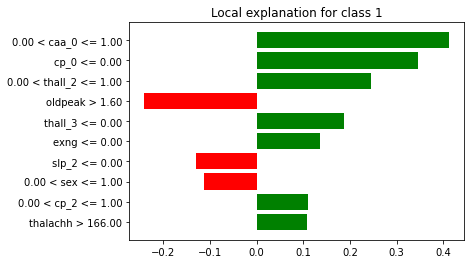

# Appendix

## Imports

In [1]:
!pip install dalex 1> /dev/null
!pip install shap 1> /dev/null
!pip install lime 1> /dev/null

In [2]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lime
import shap
import dalex as dx

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
#@title Set Credentials

kaggle_username = '' #@param {type:"string"}
kaggle_api_key = '' #@param {type:"string"}

try:
    import kaggle
except OSError:
    with open("/root/.kaggle/kaggle.json", "w+") as f:
        f.write('{"username":"' + kaggle_username + '","key":"' + kaggle_api_key + '"}')

os.system("chmod 600 /root/.kaggle/kaggle.json")

0

## Data

### Download dataset

In [4]:
# import kaggle

!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset
!unzip /content/heart-attack-analysis-prediction-dataset.zip

  0% 0.00/4.11k [00:00<?, ?B/s]
100% 4.11k/4.11k [00:00<00:00, 4.31MB/s]
Archive:  /content/heart-attack-analysis-prediction-dataset.zip
  inflating: heart.csv               
  inflating: o2Saturation.csv        


### Get data

In [5]:
df = pd.read_csv("/content/heart.csv")

#Preprocessing

### Config

In [6]:
CATEGORICAL_COLUMNS = ['cp', 'restecg', 'slp', 'caa', 'thall']
RANDOM_STATE = 2137
TEST_SIZE = 0.33

### One hot encoding

In [7]:
for col in CATEGORICAL_COLUMNS:
    one_hot = pd.get_dummies(df[col])
    one_hot = one_hot.add_prefix(col + "_")
    df = df.drop(col, axis=1)
    df = pd.concat([df, one_hot], axis=1)

In [8]:
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,output,cp_0,...,slp_2,caa_0,caa_1,caa_2,caa_3,caa_4,thall_0,thall_1,thall_2,thall_3
0,63,1,145,233,1,150,0,2.3,1,0,...,0,1,0,0,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,1,0,...,0,1,0,0,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,1,0,...,1,1,0,0,0,0,0,0,1,0
3,56,1,120,236,0,178,0,0.8,1,0,...,1,1,0,0,0,0,0,0,1,0
4,57,0,120,354,0,163,1,0.6,1,1,...,1,1,0,0,0,0,0,0,1,0


### Split data

In [9]:
X, y = df.drop('output', axis=1), df.output

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Model

In [10]:
model_rfc = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE)

In [11]:
model_rfc.fit(X, y)

RandomForestClassifier(n_estimators=150, random_state=2137)

In [12]:
print(model_rfc.predict(X.iloc[0:2]))

print(model_rfc.predict_proba(X.iloc[0:2]))

[1 1]
[[0.09333333 0.90666667]
 [0.14666667 0.85333333]]


## Explanations

### Dalex explanation

In [35]:
my_model_function = lambda m, d: m.predict(d)

explainer_rf = dx.Explainer(model_rfc, X, y, predict_function=my_model_function, label="RFC")

Preparation of a new explainer is initiated

  -> data              : 303 rows 27 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RFC
  -> predict function  : <function <lambda> at 0x7f6524d60d40> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.545, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 0.0, mean = 0.0, max = 0.0
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [36]:
explainer_rf.model_performance(cutoff=y.mean())

,recall,precision,f1,accuracy,auc
RFC,1.0,1.0,1.0,1.0,1.0


In [37]:
NO_OBSERVATIONS = 4

observations = [X.iloc[[i]] for i in range(NO_OBSERVATIONS)]

In [38]:
explanations_lime_rf = [explainer_rf.predict_surrogate(obs) for obs in observations]

In [39]:
for explanation in explanations_lime_rf:
    print(explanation.result, "\n")

               variable    effect
0  0.00 < caa_0 <= 1.00  0.414520
1          cp_0 <= 0.00  0.380238
2        oldpeak > 1.60 -0.232108
3       thall_2 <= 0.00 -0.220913
4       thall_3 <= 0.00  0.197024
5          exng <= 0.00  0.149238
6         slp_2 <= 0.00 -0.137418
7    0.00 < sex <= 1.00 -0.110450
8          cp_2 <= 0.00 -0.105152
9         slp_1 <= 0.00  0.102911 

                 variable    effect
0    0.00 < caa_0 <= 1.00  0.404007
1            cp_0 <= 0.00  0.355752
2  0.00 < thall_2 <= 1.00  0.232210
3          oldpeak > 1.60 -0.226734
4         thall_3 <= 0.00  0.196071
5            exng <= 0.00  0.145871
6           slp_2 <= 0.00 -0.119776
7           caa_2 <= 0.00  0.111881
8      0.00 < sex <= 1.00 -0.105801
9     0.00 < cp_2 <= 1.00  0.099216 

                 variable    effect
0    0.00 < caa_0 <= 1.00  0.397748
1            cp_0 <= 0.00  0.342926
2  0.00 < thall_2 <= 1.00  0.249212
3         thall_3 <= 0.00  0.211705
4            exng <= 0.00  0.151400
5         

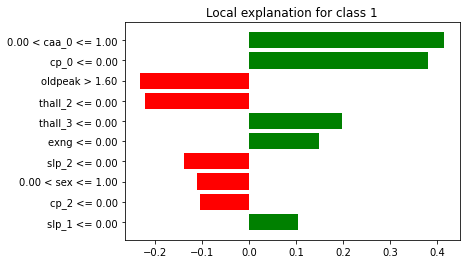

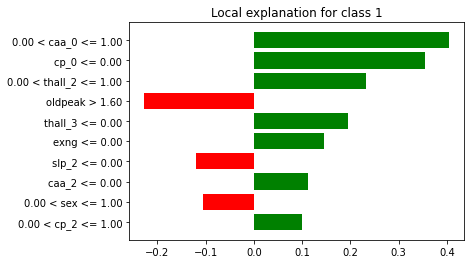

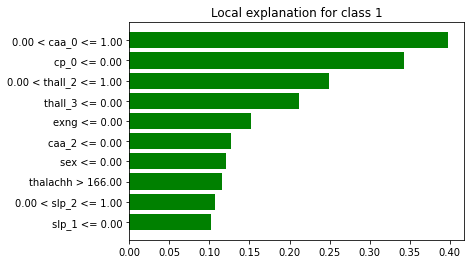

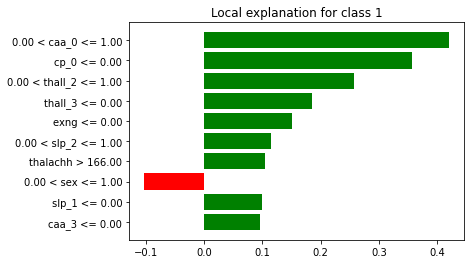

In [40]:
for explanation in explanations_lime_rf:
    explanation.plot()

### Shap explanation

In [41]:
explainer_shap_tree = shap.explainers.Tree(model_rfc, data=X, model_output='probability', random_state=RANDOM_STATE)
shap_values_tree = explainer_shap_tree(X)[:NO_OBSERVATIONS][:,:,1]

Explanation for patient nr 0 heart attack probability prediction


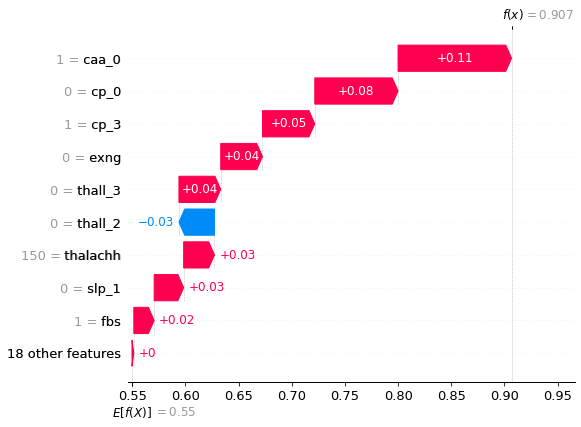

Explanation for patient nr 1 heart attack probability prediction


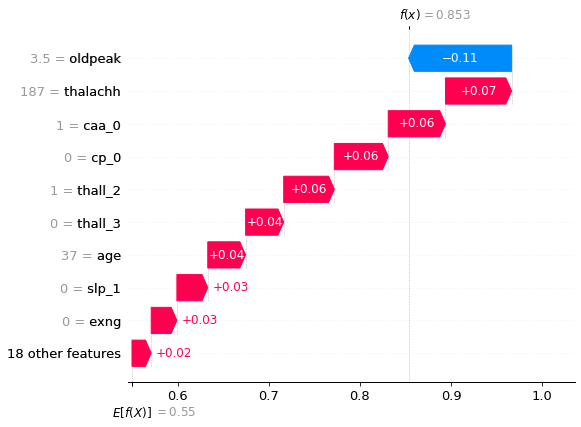

Explanation for patient nr 2 heart attack probability prediction


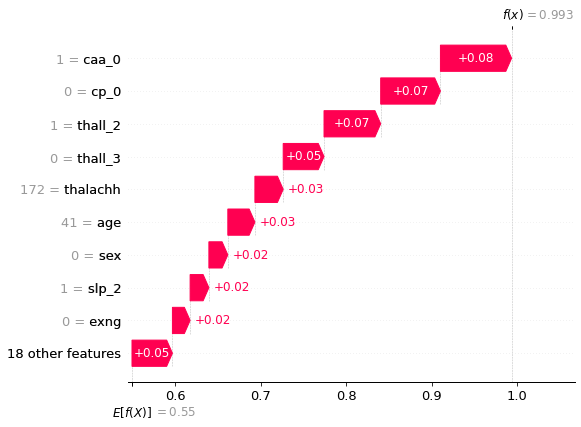

Explanation for patient nr 3 heart attack probability prediction


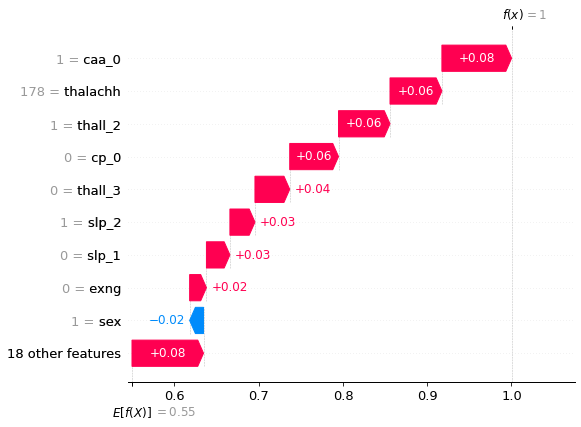

In [42]:
for i in range(NO_OBSERVATIONS):
  print(f"Explanation for patient nr {i} heart attack probability prediction")
  shap.plots.waterfall(shap_values_tree[i])

## Compare RandomForest to DecisionTree

In [43]:
model_dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

In [44]:
model_dt.fit(X,y)

DecisionTreeClassifier(random_state=2137)

### Explain predictions with Shap

In [46]:
explainer_dt = dx.Explainer(model_rfc, X, y, predict_function=my_model_function, label="DTC")

Preparation of a new explainer is initiated

  -> data              : 303 rows 27 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : DTC
  -> predict function  : <function <lambda> at 0x7f6524d60d40> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.545, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = 0.0, mean = 0.0, max = 0.0
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [47]:
explanations_lime_dt = [explainer_dt.predict_surrogate(obs) for obs in observations]

### Compare explanations

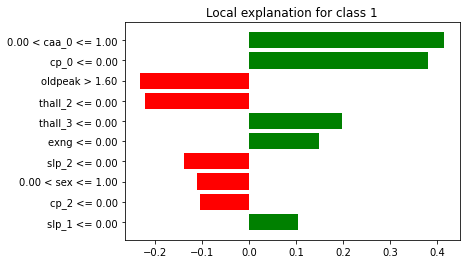

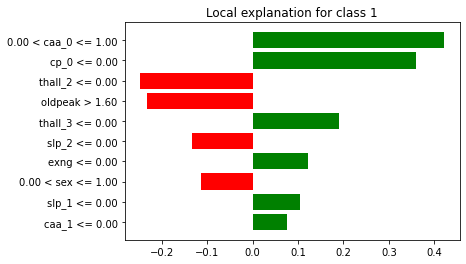

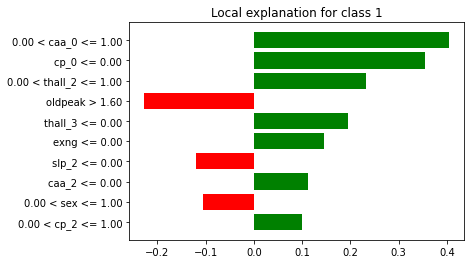

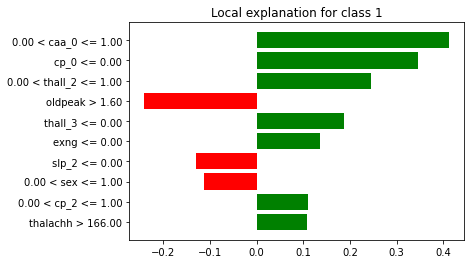

In [56]:
for i, (rf_ex, dt_ex) in enumerate(zip(explanations_lime_rf, explanations_lime_dt)):
    if i > 1:
        break
    rf_ex.plot()
    dt_ex.plot()